# 04_Evaluate.ipynb
### Evaluation notebook
Loads a trained model, runs predictions on the validation/test set, produces a classification report, confusion matrix, and saves figures to `outputs/figures/`.

In [1]:
# Install required packages (run once)
!pip install tensorflow matplotlib seaborn scikit-learn opencv-python tqdm --quiet

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

plt.rcParams['figure.figsize'] = (8,6)

In [ ]:
# Parameters - edit if needed
MODEL_PATH = '../models/mobilenet_emotion.h5'
VAL_DIR = '../data/cropped_faces/val'
INPUT_SIZE = (224, 224)
BATCH_SIZE = 32
OUT_DIR = '../outputs/figures'
os.makedirs(OUT_DIR, exist_ok=True)

In [ ]:
print('Loading model...')
model = tf.keras.models.load_model(MODEL_PATH)
model.summary()

Loading model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,266,953 (8.65 MB)

 Trainable params: 1,535,367 (5.86 MB)

 Non-trainable params: 731,584 (2.79 MB)

 Optimizer params: 2 (12.00 B)

In [5]:
print('Preparing validation generator...')
datagen = ImageDataGenerator(rescale=1.0/255)
val_gen = datagen.flow_from_directory(
    VAL_DIR,
    target_size=INPUT_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
labels = list(val_gen.class_indices.keys())
print('Classes:', labels)

Preparing validation generator...
Found 5384 images belonging to 7 classes.
Classes: ['0', '1', '2', '3', '4', '5', '6']


In [6]:
print('Predicting on validation set...')
steps = int(np.ceil(val_gen.samples / val_gen.batch_size))
preds = model.predict(val_gen, steps=steps, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes

Predicting on validation set...


/Users/utsanjan/.pyenv/versions/3.9.19/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 200ms/step


In [ ]:
print('\nClassification Report:')
report = classification_report(y_true, y_pred, target_names=labels, digits=4)
print(report)
with open(os.path.join(OUT_DIR, 'classification_report.txt'), 'w') as f:
    f.write(report)


Classification Report:
              precision    recall  f1-score   support

           0     0.4761    0.4428    0.4589       743
           1     0.7500    0.0732    0.1333        82
           2     0.4404    0.2500    0.3189       768
           3     0.7861    0.8199    0.8026      1349
           4     0.4304    0.5186    0.4704       912
           5     0.6979    0.6583    0.6775       600
           6     0.4826    0.6108    0.5392       930

    accuracy                         0.5700      5384
   macro avg     0.5805    0.4819    0.4858      5384
weighted avg     0.5709    0.5700    0.5603      5384



Computing confusion matrix...


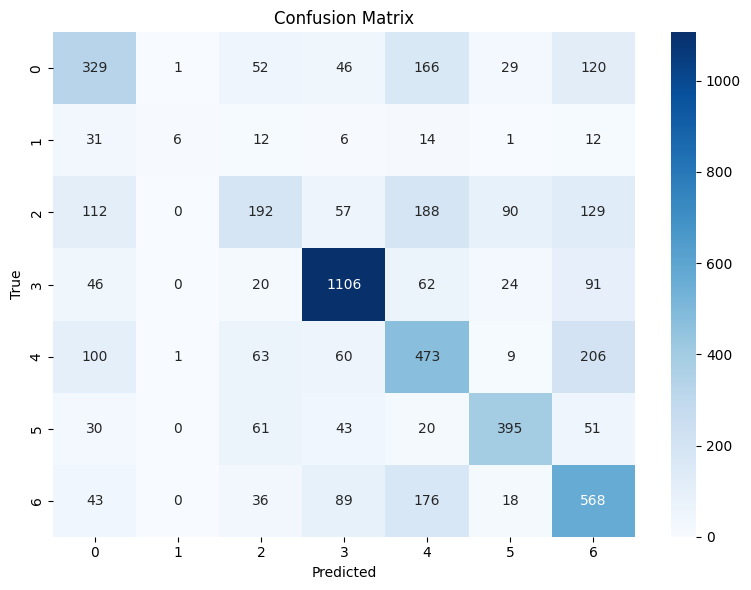

Saved confusion matrix to: ../outputs/figures/confusion_matrix.png


In [ ]:
print('Computing confusion matrix...')
cm = confusion_matrix(y_true, y_pred)
cm_path = os.path.join(OUT_DIR, 'confusion_matrix.png')
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig(cm_path, dpi=300)
plt.show()
print(f'Saved confusion matrix to: {cm_path}')

In [9]:
acc = np.sum(y_pred == y_true) / len(y_true)
print(f'Validation Accuracy: {acc*100:.2f}%')
with open(os.path.join(OUT_DIR, 'summary.txt'), 'w') as f:
    f.write(f'Validation Accuracy: {acc*100:.2f}%\n')
    f.write('Confusion matrix saved to: ' + cm_path + '\n')
    f.write('Classification report saved to: ' + os.path.join(OUT_DIR, 'classification_report.txt') + '\n')

Validation Accuracy: 57.00%


## Optional: Per-class precision/recall bar chart
This visualizes precision and recall for each class using the saved classification report.

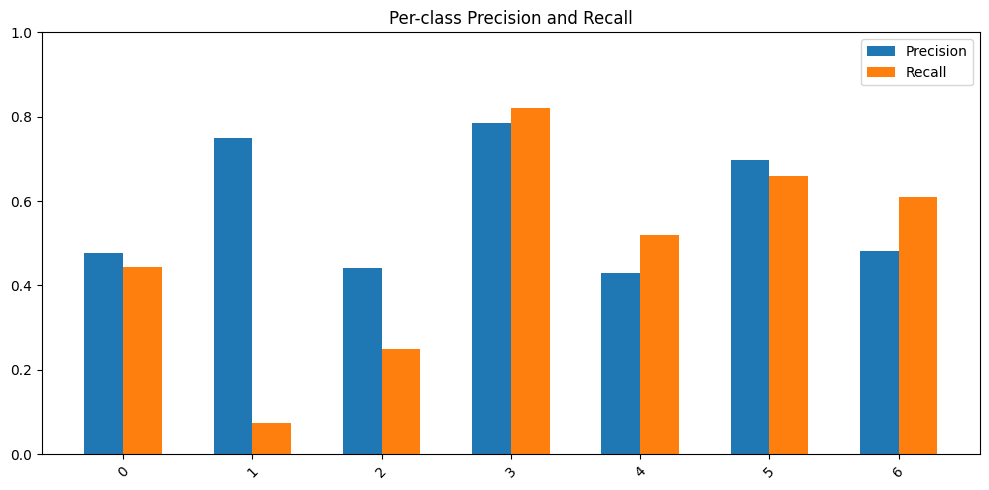

Saved precision/recall plot to: ../outputs/figures/precision_recall.png


In [10]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
recall = recall_score(y_true, y_pred, average=None, zero_division=0)
x = np.arange(len(labels))
plt.figure(figsize=(10,5))
plt.bar(x - 0.15, precision, width=0.3, label='Precision')
plt.bar(x + 0.15, recall, width=0.3, label='Recall')
plt.xticks(x, labels, rotation=45)
plt.ylim(0,1)
plt.legend()
plt.title('Per-class Precision and Recall')
pr_path = os.path.join(OUT_DIR, 'precision_recall.png')
plt.tight_layout()
plt.savefig(pr_path, dpi=300)
plt.show()
print(f'Saved precision/recall plot to: {pr_path}')
